In [ ]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
name_map = {
    "arima": "ARIMA",
    "TCN": "TCN",
    "N-HiTS": "N-HiTS",
    "text-davinci-003": "GPT-3\n(interp.)",
    "text-davinci-003-Nan": "GPT-3\n(NaNs)"
}

with open('eval/missing_expt/missing.pkl','rb') as f:
    all_output = pickle.load(f)

df = []
for dataset in all_output:
    print(dataset)
    for method in all_output[dataset]:
        print(method)
        
        if method == 'p':
            continue

        gpt_nll = all_output[dataset]['text-davinci-003-Nan'][0]

        probs = all_output[dataset]['p']
        nlls = all_output[dataset][method]
        for p, nll in zip(probs, nlls):
            df.append({
                "dataset": dataset,
                "method": method,
                "nan_fraction": p,
                "nll/d": nll - gpt_nll
            })

df = pd.DataFrame(df)
print(df)

df['ll/d'] = -1 * df['nll/d']
df['method'] = df['method'].apply(lambda x: name_map[x])

print(df)

sns.set(style='whitegrid', font_scale=1.25)
fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5))

sns.lineplot(
    df,
    x = "nan_fraction",
    y = "ll/d",
    hue="method",
    hue_order=['TCN', 'ARIMA', "N-HiTS", "GPT-3\n(interp.)", "GPT-3\n(NaNs)"],
    errorbar="se",
    palette='Dark2',
    linewidth=3,
    ax=ax,
)

ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()

handles = handles[:1] + handles[2:3] + handles[1:2] + handles[3:]
labels = labels[:1] + labels[2:3] + labels[1:2] + labels[3:]
# handles = [val for pair in zip(handles[:2], handles[-2:]) for val in pair] + handles[2:3]
# labels = [val for pair in zip(labels[:2], labels[-2:]) for val in pair] + labels[2:3]

leg = ax.legend(
    handles=handles,
    labels=labels,
    # markerscale=,
    # linewidth=3,
    # bbox_to_anchor=(0.5, -0.6),
    loc='lower left',
    borderaxespad=0.3,
    columnspacing=0.5,
    ncol=2,
    fontsize=15,
    # zorder=10,
)

for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

plt.ylim((-7,1))
plt.xlabel('NaN Fraction')
plt.ylabel('Log Likelihood / D')

plt.savefig('missing_ll.pdf', bbox_inches='tight')
plt.show()

In [ ]:
import cloudpickle
from data.metrics import calculate_crps
from data.small_context import get_datasets

datasets = get_datasets()

with open(f'eval/missing_expt/missing_full.pkl','rb') as f:
    all_output = cloudpickle.load(f)

df = []
for dsname in ['AirPassengersDataset']:
    print(dsname)
    output_dict = all_output[dsname]

    train, test = datasets[dsname]
    ps = output_dict['p']
    tmae, crps = defaultdict(list), defaultdict(list)
    for seed, inner_dict in output_dict.items():
        if seed == 'p':
            continue 
        
        # print(seed)
        for model, results in inner_dict.items():
            # print(model)
            if model in ['p','gp-Nan', 'gp']:
                continue

            # print([x['samples'].shape for x in results])

            nlls = [x['NLL/D'] for x in results]
            
            if 'gp' in model:
                samples = [x['samples'] for x in results]
            else:
                samples = [x['samples'].values for x in results]
            
            crps[model].append([
                calculate_crps(test.values, x, 20) for x in samples
            ])
            tmae[model].append([
                np.abs(test.values-x['median']).mean()/np.abs(test.values).mean() for x in results
            ])

    
    # print(crps)
    # print(tmae)
    ps = [0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for model in crps:
        # print(crps[model])
        for i, (x, y) in enumerate(zip(crps[model], tmae[model])):
        # tmae[model] = np.mean(np.array(tmae[model]), 0)
        # crps[model] = np.mean(np.array(crps[model]), 0)
            x = np.array(x)
            y = np.array(y)

            for c, m, p in zip(x, y, ps):
                df.append({
                    "dataset": dsname,
                    "method": model,
                    "nan_fraction": p,
                    "crps": c,
                    "mae": m,
                    "seed": i,
                })

df = pd.DataFrame(df)
df['method'] = df['method'].apply(lambda x: name_map[x])

sns.set(style='whitegrid', font_scale=1.25)
fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5))

sns.lineplot(
    df,
    x = "nan_fraction",
    y = "crps",
    hue="method",
    hue_order=['TCN', 'ARIMA', "N-HiTS",  "GPT-3\n(interp.)", "GPT-3\n(NaNs)"],
    errorbar="se",
    palette='Dark2',
    linewidth=3,
    ax=ax,
)

ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()

# handles = handles[:1] + handles[2:3] + handles[1:2] + handles[3:]
# labels = labels[:1] + labels[2:3] + labels[1:2] + labels[3:]
# handles = [val for pair in zip(handles[:2], handles[-2:]) for val in pair] + handles[2:3]
# labels = [val for pair in zip(labels[:2], labels[-2:]) for val in pair] + labels[2:3]

leg = ax.legend(
    handles=handles,
    labels=labels,
    # markerscale=,
    # linewidth=3,
    # bbox_to_anchor=(0.5, -0.6),
    loc='upper left',
    borderaxespad=0.3,
    columnspacing=0.5,
    ncol=2,
    fontsize=15,
    # zorder=10,
)

for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

plt.xlabel('NaN Fraction')
plt.ylabel('CRPS')

plt.savefig('missing_crps.pdf', bbox_inches='tight')
plt.show()

linear: 0.9333333333333333
log: 0.17647058823529413
square: 0.8235294117647058
linear_cos: 0.29411764705882354
sinc: 0.0
sigmoid: 0.05263157894736842
beat: 0.0
exp: 0.8125
gaussian_wave: 0.6
sine: 0.125
x_times_sine: 0.0


/var/folders/4z/0371zfqj5mx0rlct4r3qclfm0000gn/T/ipykernel_84564/2487969271.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


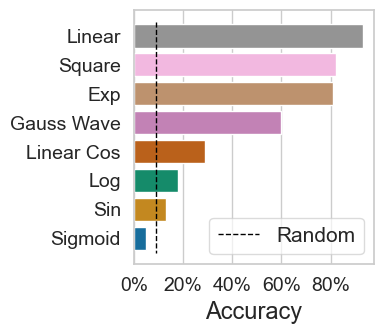

In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

sns.set(style='whitegrid', font_scale=1.)

with open(f'../gpt4_cot.pkl','rb') as f:
    data_dict = pickle.load(f)

for task in data_dict:
    answers = [b.split(":")[-1].strip() for a,b in data_dict[task]]
    acc = np.mean([int(a == task) for a in answers])
    print(f"{task}: {acc}")

df = pd.DataFrame([
    {"method": "GPT4 + CoT", "Task": "Linear", "Accuracy": 0.93},
    {"method": "GPT4 + CoT", "Task": "Square", "Accuracy": 0.82},
    {"method": "GPT4 + CoT", "Task": "Exp", "Accuracy": 0.81}, 
    {"method": "GPT4 + CoT", "Task": "Gauss Wave", "Accuracy": 0.60},
    {"method": "GPT4 + CoT", "Task": "Linear Cos", "Accuracy": 0.29},
    {"method": "GPT4 + CoT", "Task": "Log", "Accuracy": 0.18},
    {"method": "GPT4 + CoT", "Task": "Sin", "Accuracy": 0.13},
    {"method": "GPT4 + CoT", "Task": "Sigmoid", "Accuracy": 0.05},
    # {"method": "GPT4 + CoT", "Task": "Sinc", "Accuracy": 0.0},
    # {"method": "GPT4 + CoT", "Task": "Beat", "Accuracy": 0.0},
    # {"method": "GPT4 + CoT", "Task": "X * Sin", "Accuracy": 0.0},
])

fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))

# import IsleOfDogs2_6 palette 
# from palettable import colorbrewer
# palette = colorbrewer.qualitative.Set2_8.mpl_colors

#set palette to sns colorblind
palette = sns.color_palette("colorblind", 8)[::-1]

sns.barplot(
    y='Task',
    x='Accuracy',
    # hue='Type',
    palette=palette,
    data=df,
    ax=ax, 
)

ax.plot([1./11, 1./11], [-0.5, 7.5], color='black', linestyle='--', linewidth=1, label='Random')
# ax.set_ylim((-0.5, 7.5))

ax.legend(
    # loc='lower right', 
    frameon=True, 
    framealpha=0.7, 
    fontsize=15
)
ax.set_xticklabels(
    ['{:,.0%}'.format(x) for x in ax.get_xticks()], 
    fontsize=14
)
ax.set_xlabel(ax.get_xlabel(), fontsize=17)

ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
ax.set_ylabel("")

plt.tight_layout()
plt.savefig('gpt4_classification.pdf', dpi=300, bbox_inches='tight')
plt.show()